In [292]:
import gzip
import numpy
from urllib.request import urlopen
import scipy.optimize
import random
from collections import defaultdict
import string
import nltk
from nltk.corpus import stopwords 
from nltk.stem.porter import *
from nltk import word_tokenize 
from nltk.util import ngrams
import pandas as pd
import json
import itertools
import unidecode
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

In [31]:
def parseData(fname):
    for l in open(fname):
        yield eval(l)

def parseDataFromURL(fname):
    for l in urlopen(fname):
        yield eval(l)
        
def readGz(path):
    for l in gzip.open(path, 'rt'):
        yield eval(l)

def readCSV(path):
    f = gzip.open(path, 'rt')
    f.readline()
    for l in f:
        yield l.strip().split(',')

In [50]:
print("Reading data...")
data = pd.read_csv("wine-reviews/winemag-data-130k-v2.csv").drop(columns=['Unnamed: 0'])
print("done")

Reading data...
done


In [51]:
data

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
...,...,...,...,...,...,...,...,...,...,...,...,...,...
129966,Germany,Notes of honeysuckle and cantaloupe sweeten th...,Brauneberger Juffer-Sonnenuhr Spätlese,90,28.0,Mosel,NaN,NaN,Anna Lee C. Iijima,NaN,Dr. H. Thanisch (Erben Müller-Burggraef) 2013 ...,Riesling,Dr. H. Thanisch (Erben Müller-Burggraef)
129967,US,Citation is given as much as a decade of bottl...,NaN,90,75.0,Oregon,Oregon,Oregon Other,Paul Gregutt,@paulgwine,Citation 2004 Pinot Noir (Oregon),Pinot Noir,Citation
129968,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser
129969,France,"A dry style of Pinot Gris, this is crisp with ...",NaN,90,32.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Domaine Marcel Deiss 2012 Pinot Gris (Alsace),Pinot Gris,Domaine Marcel Deiss


In [63]:
variety_dist = data.groupby('variety').size().sort_values(ascending=False)

In [445]:
variety_color = {'Pinot Noir': '#780D30',
                'Chardonnay': '#F0E9D7',
                'Cabernet Sauvignon': '#631529',
                'Red Blend': '#722F37',
                'Bordeaux-style Red Blend': '#4C1C24',
                'Riesling': '#F7F9B4',
                'Sauvignon Blanc': '#F1E3A4',
                'Syrah': '#6A282C',
                'Rosé': '#9F5057',
                'Merlot': '#733438',
                'Nebbiolo': '#5E1224',
                'Zinfandel': '#5D3935',
                'Sangiovese': '#722F37',
                'Malbec': '#722F37',
                'Portuguese Red': '#71100F',
                'White Blend': '#F1F2A5',
                'Sparkling Blend': '#F7E7CE',
                'Tempranillo': '#722F37',
                'Rhône-style Red Blend': '#4C1C24',
                'Pinot Gris': '#F7E7CE'}

In [439]:
sorted(sorted(variety_color.items(), key=lambda kv: kv[0], reverse=True))

[('Bordeaux-style Red Blend', '#4C1C24'),
 ('Cabernet Sauvignon', '#631529'),
 ('Chardonnay', '#F0E9D7'),
 ('Malbec', '#722F37'),
 ('Merlot', '#733438'),
 ('Nebbiolo', '#5E1224'),
 ('Pinot Gris', 'F7E7CE'),
 ('Pinot Noir', '#780D30'),
 ('Portuguese Red', '#71100F'),
 ('Red Blend', '#722F37'),
 ('Rhône-style Red Blend', '#4C1C24'),
 ('Riesling', '#F7F9B4'),
 ('Rosé', '#9F5057'),
 ('Sangiovese', '#722F37'),
 ('Sauvignon Blanc', '#F1E3A4'),
 ('Sparkling Blend', 'F7E7CE'),
 ('Syrah', '#6A282C'),
 ('Tempranillo', '#722F37'),
 ('White Blend', '#F1F2A5'),
 ('Zinfandel', '#5D3935')]

In [208]:
variety_20 = list(variety_dist[:20].index)
variety_20

['Pinot Noir',
 'Chardonnay',
 'Cabernet Sauvignon',
 'Red Blend',
 'Bordeaux-style Red Blend',
 'Riesling',
 'Sauvignon Blanc',
 'Syrah',
 'Rosé',
 'Merlot',
 'Nebbiolo',
 'Zinfandel',
 'Sangiovese',
 'Malbec',
 'Portuguese Red',
 'White Blend',
 'Sparkling Blend',
 'Tempranillo',
 'Rhône-style Red Blend',
 'Pinot Gris']

In [212]:
variety_fn = [unidecode.unidecode(word.lower().replace(" ", "_")) for word in variety_20]
variety_fn

['pinot_noir',
 'chardonnay',
 'cabernet_sauvignon',
 'red_blend',
 'bordeaux-style_red_blend',
 'riesling',
 'sauvignon_blanc',
 'syrah',
 'rose',
 'merlot',
 'nebbiolo',
 'zinfandel',
 'sangiovese',
 'malbec',
 'portuguese_red',
 'white_blend',
 'sparkling_blend',
 'tempranillo',
 'rhone-style_red_blend',
 'pinot_gris']

In [449]:
fn_to_name = {}
for fn, name in zip(variety_fn, variety_20):
    fn_to_name[fn] = name
fn_to_name

{'pinot_noir': 'Pinot Noir',
 'chardonnay': 'Chardonnay',
 'cabernet_sauvignon': 'Cabernet Sauvignon',
 'red_blend': 'Red Blend',
 'bordeaux-style_red_blend': 'Bordeaux-style Red Blend',
 'riesling': 'Riesling',
 'sauvignon_blanc': 'Sauvignon Blanc',
 'syrah': 'Syrah',
 'rose': 'Rosé',
 'merlot': 'Merlot',
 'nebbiolo': 'Nebbiolo',
 'zinfandel': 'Zinfandel',
 'sangiovese': 'Sangiovese',
 'malbec': 'Malbec',
 'portuguese_red': 'Portuguese Red',
 'white_blend': 'White Blend',
 'sparkling_blend': 'Sparkling Blend',
 'tempranillo': 'Tempranillo',
 'rhone-style_red_blend': 'Rhône-style Red Blend',
 'pinot_gris': 'Pinot Gris'}

In [136]:
wine_data = data.groupby('variety').get_group('Pinot Noir')
descriptions = list(wine_data['description'])
punctuation = set(string.punctuation)
for d in descriptions:
    r = ''.join([c for c in d.lower() if not c in punctuation])
    d = r

In [159]:
vectorizer = TfidfVectorizer(ngram_range=(1,1), max_features=10000)
X = vectorizer.fit_transform(descriptions)

In [160]:
feature_names = vectorizer.get_feature_names()

In [172]:
doc = 0
feature_index = X[doc,:].nonzero()[1]
tfidf_scores = list(zip(feature_index, [X[doc, x] for x in feature_index]))

In [173]:
word_scores = {feature_names[i]: s for i, s in tfidf_scores}

In [402]:
sorted_scores = dict(sorted(word_scores.items(), key=lambda kv: kv[1], reverse=True)[:10])
sorted_scores

{'pear': 0.43040606691878464,
 'fruit': 0.26849390881272006,
 'palate': 0.17799516319054123,
 'apple': 0.17027489105215632,
 'acidity': 0.15140311471388207,
 'ripe': 0.14454065059087326,
 'fresh': 0.1282422982987273,
 'dry': 0.1273844902833512,
 'notes': 0.11623298608346187,
 'finish': 0.10765490592970085}

In [405]:
total = sum(list(sorted_scores.values()))*10
for k,v in sorted_scores.items():
    sorted_scores[k] = v/total*100
sorted_scores

{'pear': 2.361458040494766,
 'fruit': 1.4731137605207265,
 'palate': 0.9765850009841875,
 'apple': 0.934227097327042,
 'acidity': 0.8306855550540196,
 'ripe': 0.7930340851365573,
 'fresh': 0.7036118440825833,
 'dry': 0.6989054103429004,
 'notes': 0.6377217717270236,
 'finish': 0.5906574343301954}

In [185]:
wine_words = {'variety': [], 'document': []}
for wine in variety_20:
    wine_words['variety'].append(wine)
    wine_data = data.groupby('variety').get_group(wine)
    descriptions = list(wine_data['description'])
    punctuation = set(string.punctuation)
    stop_words = set(stopwords.words('english')) 
    document_string = ''
    for d in descriptions:
        r = ''.join([c for c in d.lower() if not c in punctuation])
        document_string = document_string + r
    wine_words['document'].append(document_string)

In [186]:
wine_words_df = pd.DataFrame.from_dict(wine_words)
wine_words_df

,variety,document
0,Pinot Noir,much like the regular bottling from 2012 this ...
1,Chardonnay,building on 150 years and six generations of w...
2,Cabernet Sauvignon,soft supple plum envelopes an oaky structure i...
3,Red Blend,ripe aromas of dark berries mingle with ample ...
4,Bordeaux-style Red Blend,a blend of merlot and cabernet franc this wine...
5,Riesling,pineapple rind lemon pith and orange blossom s...
6,Sauvignon Blanc,this shows a tart green gooseberry flavor that...
7,Syrah,baked red cherry crushed clove iron and rose p...
8,Rosé,pale copper in hue this wine exudes passion fr...
9,Merlot,this wine from the geneseo district offers aro...


In [413]:
documents = list(wine_words_df['document'])
vectorizer = TfidfVectorizer(ngram_range=(1,1), max_features=5000, stop_words='english')
X = vectorizer.fit_transform(documents)

In [414]:
feature_names = vectorizer.get_feature_names()

In [432]:
variety_word_counts = {}
for i in range(len(documents)):
    wordCount = defaultdict(int)
    token = nltk.word_tokenize(documents[i])
    unigrams = list(ngrams(token, 1))
    for unigram in unigrams:
        wordCount[unigram[0]] += 1
    variety_word_counts[variety_20[i]] = {w:n for w,n in wordCount.items()}

In [446]:
for i in range(len(variety_20)):
    wine_name = variety_20[i].lower().split()
    not_useful = ['wine', 'flavor', 'flavors', 'white', 'red', 'drink'] + wine_name
    feature_index = X[doc,:].nonzero()[1]
    tfidf_scores = list(zip(feature_index, [X[i, x] for x in feature_index]))
    word_scores = {feature_names[w]: s for w, s in tfidf_scores if feature_names[w] not in not_useful}
    sorted_words = dict(sorted(word_scores.items(), key=lambda kv: kv[1], reverse=True))
    top_words = dict(itertools.islice(sorted_words.items(), 10))
    variety_data = []
    for word, score in top_words.items():
        new_score = np.power(1000, score)
        variety_data.append({'name': word, 'color': variety_color[variety_20[i]], 'value': variety_word_counts[variety_20[i]][word]/new_score})
    plot_series = {'name': variety_20[i], 'data': variety_data}
    with open('bubble_charts/' + variety_fn[i] + '.json', 'w') as outfile:
        json.dump(plot_series, outfile)

# Price

In [270]:
standardized_price = (data['price']-data['price'].mean())/data['price'].std()

In [271]:
data['standardized_price'] = standardized_price

In [358]:
data.loc[(data['variety'] == 'Sparkling Blend')]

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,age,standardized_price
339,Spain,"Red in color, with berry and apple aromas, thi...",1887 Rosado,82,13.0,Catalonia,Cava,NaN,Michael Schachner,@wineschach,Cavas Hill NV 1887 Rosado Sparkling (Cava),Sparkling Blend,Cavas Hill,130.0,-0.545153
342,Spain,"Funky, yeasty aromas of cinnamon, spent lees a...",NaN,82,11.0,Catalonia,Cava,NaN,Michael Schachner,@wineschach,Bellisco NV Sparkling (Cava),Sparkling Blend,Bellisco,NaN,-0.593907
427,US,A touch blossomy against a core of ripe raspbe...,Cuvée Gabriella Brut Rosé,89,35.0,New York,North Fork of Long Island,Long Island,Anna Lee C. Iijima,NaN,Macari 2010 Cuvée Gabriella Brut Rosé Sparklin...,Sparkling Blend,Macari,7.0,-0.008858
456,US,"Thickly moussed, Roederer's Brut, 60% Chardonn...",Brut,92,23.0,California,Anderson Valley,NaN,Virginie Boone,@vboone,Roederer Estate NV Brut Sparkling (Anderson Va...,Sparkling Blend,Roederer Estate,NaN,-0.301383
458,Italy,"From one of Franciacorta's leading producers, ...",Gran Cuvée Pas Operé,92,50.0,Lombardy,Franciacorta,NaN,Kerin O’Keefe,@kerinokeefe,Bellavista 2006 Gran Cuvée Pas Operé Sparkling...,Sparkling Blend,Bellavista,11.0,0.356797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129621,Ukraine,Fresh apple notes on the nose of this off-dry ...,KrimSekt White Collection Semi-Dry,84,13.0,Ukraine,NaN,NaN,Anna Lee C. Iijima,NaN,Artemovsk 2008 KrimSekt White Collection Semi-...,Sparkling Blend,Artemovsk,9.0,-0.545153
129694,US,This is one of Chandon's sweeter bubblies. It ...,Brut Classic,87,22.0,California,California,California Other,NaN,NaN,Chandon NV Brut Classic Sparkling (California),Sparkling Blend,Chandon,NaN,-0.325760
129695,US,"Honey-sweet flavors of raspberries, pink grape...",Rosé,87,22.0,California,California,California Other,NaN,NaN,Chandon NV Rosé Sparkling (California),Sparkling Blend,Chandon,NaN,-0.325760
129706,US,"Mostly Pinot Noir, with a few drops of Chardon...",VA de VI Ultra Cuvée,87,24.0,California,Sonoma County,Sonoma,NaN,NaN,Gloria Ferrer NV VA de VI Ultra Cuvée Sparklin...,Sparkling Blend,Gloria Ferrer,NaN,-0.277006


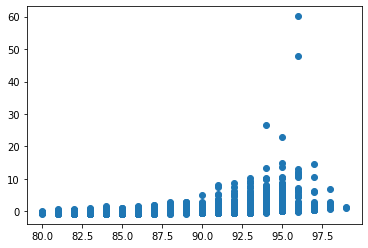

In [299]:
wine_data = data.groupby('variety').get_group('Pinot Noir')
plt.scatter(wine_data['points'], wine_data['standardized_price'])
plt.show()

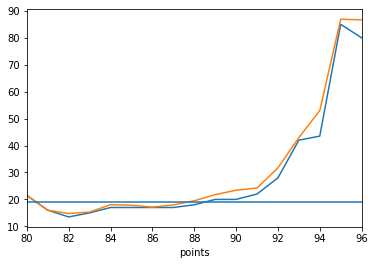

In [315]:
wine_data.groupby('points').price.median().plot(kind='line', x='points', y='price')
wine_data.groupby('points').price.mean().plot(kind='line', x='points', y='price')
plt.axhline(wine_data['price'].median())

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


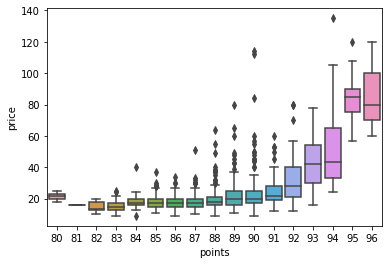

In [293]:
wine_data['points'] = pd.Categorical(wine_data['points'])
ax = sns.boxplot(x='points', y='price', data=wine_data)

In [447]:
for i in range(len(variety_20)):
    x_axis = list(range(80,101))
    wine_data = data.groupby('variety').get_group(variety_20[i])
    price_dict = wine_data.groupby('points').price.median().to_frame().reset_index().to_dict(orient='records')
    price_data = {}
    for dic in price_dict:
        if not pd.isnull(dic['price']):
            price_data[dic['points']] = int(dic['price'])
        else:
            price_data[dic['points']] = 'null'
    for x in x_axis:
        if x not in price_data:
            price_data[x] = 'null'
    price_series = {'name': variety_20[i], 'color': variety_color[variety_20[i]], 'marker': {'symbol': 'square'}, 'data': list(price_data.values())}
    with open('line_charts/' + variety_fn[i] + '.json', 'w') as outfile:
        json.dump(price_series, outfile)

# Age

In [356]:
#wine_data = data.groupby('variety').get_group('Pinot Noir')
age = [re.findall(r'[1|2]\d{3}', title) for title in data['title'].values]
for i in range(len(age)):
    if not age[i]:
        age[i] = np.nan
    else:
        age[i] = 2017 - int(age[i][0])

In [357]:
data['age'] = age
data

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,age,standardized_price
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,4.0,NaN
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,6.0,-0.496399
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,4.0,-0.520776
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,4.0,-0.545153
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,5.0,0.722453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129966,Germany,Notes of honeysuckle and cantaloupe sweeten th...,Brauneberger Juffer-Sonnenuhr Spätlese,90,28.0,Mosel,NaN,NaN,Anna Lee C. Iijima,NaN,Dr. H. Thanisch (Erben Müller-Burggraef) 2013 ...,Riesling,Dr. H. Thanisch (Erben Müller-Burggraef),4.0,-0.179498
129967,US,Citation is given as much as a decade of bottl...,NaN,90,75.0,Oregon,Oregon,Oregon Other,Paul Gregutt,@paulgwine,Citation 2004 Pinot Noir (Oregon),Pinot Noir,Citation,13.0,0.966223
129968,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser,4.0,-0.130744
129969,France,"A dry style of Pinot Gris, this is crisp with ...",NaN,90,32.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Domaine Marcel Deiss 2012 Pinot Gris (Alsace),Pinot Gris,Domaine Marcel Deiss,5.0,-0.081989


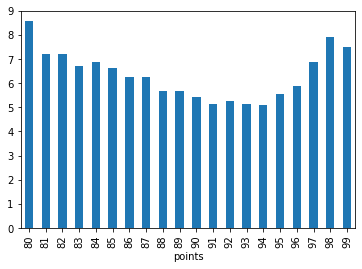

In [337]:
wine_data = data.groupby('variety').get_group('Pinot Noir')
wine_data.groupby('points').age.mean().plot(kind='bar')

In [448]:
for i in range(len(variety_20)):
    wine_data = data.groupby('variety').get_group(variety_20[i])
    popular_ages = wine_data[pd.notnull(wine_data['age'])].groupby('points').age.agg(lambda x:x.value_counts().index[0])
    ages_dict = popular_ages.to_frame().reset_index().to_dict(orient='records')
    ages_data = [[dic['points'], int(dic['age'])] for dic in ages_dict]
    ages_labels = {
                    'enabled': 'true',
                    'rotation': -90,
                    'color': '#FFFFFF',
                    'align': 'right',
                    'y': 10,
                    'style': {
                        'fontSize': '10px',
                        'fontFamily': 'Verdana, sans-serif'
                    }
                }
    ages_series = {'name': variety_20[i], 'color': variety_color[variety_20[i]], 'data': ages_data, 'dataLabels': ages_labels}
    with open('bar_charts/' + variety_fn[i] + '.json', 'w') as outfile:
        json.dump(ages_series, outfile)
    